<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG16-damage/vecicle_damage_VGG16_batch16_epoch_80_changed_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1050 images belonging to 2 classes.
Found 224 images belonging to 2 classes.
Found 224 images belonging to 2 classes.
58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/80
32/32 [==============================] - 327s 10s/step - loss: 0.5868 - accuracy: 0.6916 - val_loss: 0.4316 - val_accuracy: 0.8571
Epoch 2/80
32/32 [==============================] - 19s 601ms/step - loss: 0.4062 - accuracy: 0.8301 - val_loss: 0.3975 - val_accuracy: 0.8080
Epoch 3/80
32/32 [==============================] - 18s 562ms/step - loss: 0.3591 - accuracy: 0.8546 - val_loss: 0.3832 - val_accuracy: 0.8080
Epoch 4/80
32/32 [==============================] - 19s 570ms/step - loss: 0.3425 - accuracy: 0.8517 - val_loss: 0.3392 - val_accuracy: 0.8214
Epoch 5/80
32/32 [==============================] - 20s 615ms/step - loss: 0.3028 - accuracy: 0.8811 - val_loss: 0.3596 - val_accuracy: 0.8080
Epoch 6/80
32/32 [==============================] - 20s 601ms/step - loss: 0.2969 - accuracy: 0.8

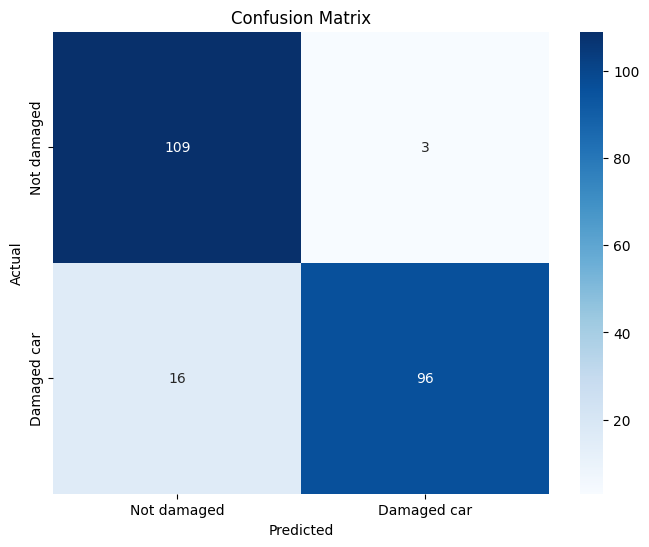

Test loss: 0.2068
Test accuracy: 91.52
Train loss: 0.1344
Train accuracy: 94.92
Recall: 0.92
Precision: 0.92
F1-score: 0.91


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator# Importing ImageDataGenerator for real-time data augmentation on image data
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten #Flatten layer is used to flatten the input data from a multi-dimensional shape into one-dimensional array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns # Added seaborn for visualization (attractive and informative statistical graphics)

# Define your data directories
train_dir = '/content/drive/MyDrive/damaged dataset/train'
val_dir = '/content/drive/MyDrive/damaged dataset/validation'
test_dir = '/content/drive/MyDrive/damaged dataset/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32  # Batch size is the number of samples processed by the model at each iteration during training.

# Create data generators
train_datagen = ImageDataGenerator(
    # This initializes an ImageDataGenerator object named train_datagen responsible for generating augmented images from the original dataset during training.

    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' # Fill newly created pixels with values from the nearest existing pixel(as it left shift or other).
)

val_datagen = ImageDataGenerator(rescale=1./255)# Rescale pixel values of validation images to [0, 1](for normalization process).
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,# Directory containing training images
    target_size=img_size,# Resize all images to the specified dimensions
    batch_size=batch_size,# Number of images in each batch
    class_mode='categorical'# For multi-class classification, use 'categorical' to get one-hot encoded labels

)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Flatten the output of VGG16
x = Flatten()(base_model.output)

# Add a fully connected layer for classification
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: car and damaged car

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=80,# Number of times the entire training dataset is passed through the model
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)


# Calculate recall

y_true = []# List to store true labels
y_pred = []# List to store predicted labels
for i in range(test_generator.n // batch_size):
      # Retrieve the next batch of input images and their corresponding true labels
    batch_x, batch_y = next(test_generator)
        # Extract true labels from batch_y and append to y_true list
    y_true.extend(np.argmax(batch_y, axis=1))
    # Obtain model predictions for the input images in the current batch
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))


# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not damaged', 'Damaged car'], yticklabels=['Not damaged', 'Damaged car'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_VGG16_batch16_epoch_80_changed_new_dataset.h5')


